## Import libraries

In [29]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Load the training and testing set

In [30]:
df_train = pd.read_csv('../data/training_set.csv', index_col = 0)
df_test = pd.read_csv('../data/testing_set.csv', index_col = 0)

In [31]:
X_train = df_train.drop("price", axis = 1)
y_train = df_train["price"]
X_test = df_test.drop("price", axis = 1)
y_test = df_test["price"]

## XGBoost

#### First, we try the default hyperparameters of XGBoost

In [32]:
# params = trial.best_params
model = xgb.XGBRegressor()
# model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)
r2_train = r2_score(y_train, model.predict(X_train))
r2_test = r2_score(y_test, y_preds)
print("R2 score for XGBoost model (test):", r2_test)
print("R2 score for XGBoost model (train):", r2_train)

R2 score for XGBoost model (test): 0.8201044299626159
R2 score for XGBoost model (train): 0.9957583381538956


In [34]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

#### Now we utilize some hyperparameter tuning method to improve this

##### 1. Grid Search Cross Validation

In [43]:
params = {
        'gamma': [0, 0.5, 1, 5],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 6, 10],
        'n_estimators':[50,100,200],
        'reg_alpha': [0, 0.5, 1, 5],
        'reg_lambda': [0, 0.5, 1, 5]
        }

In [44]:
model = xgb.XGBRegressor() 

In [45]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=params,
    scoring = 'r2',
    n_jobs = -1,
    cv = 5,
    verbose=True
)

In [46]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.5, 1, 5], 'max_depth': [3, 4, 6, 10],
                         'n_estimators': [50, 100, 200],
                         'reg_alpha': [0, 0.5, 1, 5],
                         'reg_lambda': [0, 0.5, 1, 5]},
             scoring='r2', verbose=True)

In [47]:
print('Best Score: %s' % grid_search.best_score_)
print('Best Hyperparameters: %s' % grid_search.best_params_)

Best Score: 0.7816049254069652
Best Hyperparameters: {'colsample_bytree': 0.6, 'gamma': 0, 'max_depth': 4, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 1}


In [48]:
tuned_model = xgb.XGBRegressor(**grid_search.best_params_) 
tuned_model.fit(X_train, y_train)
y_preds = tuned_model.predict(X_test)
r2_train = r2_score(y_train, tuned_model.predict(X_train))
r2_test = r2_score(y_test, y_preds)
print("R2 score for XGBoost model (test):", r2_test)
print("R2 score for XGBoost model (train):", r2_train)

R2 score for XGBoost model (test): 0.8069958462026687
R2 score for XGBoost model (train): 0.9630734393870292


#### 2. Bayesian Optimization

As hyperparameters' space of XGboost are very large, we use Bayesian optimization to find the best one

In [49]:
def objective(trial):
    """Define the objective function"""
    # train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.15,random_state=42)
    params = {
        'max_depth': trial.suggest_categorical('max_depth', [6,8,12,18]),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'random_state': 1
    }

    # Fit the model
    model = xgb.XGBRegressor(**params)  
    r2 = cross_val_score(model, X_train, y_train, cv=5, scoring = 'r2').mean()
    return r2

In [50]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=80)

[I 2023-02-09 20:23:21,284] A new study created in memory with name: no-name-bc1dfa9e-e3e9-4c77-9b20-ba6b8b5e9e74
[I 2023-02-09 20:23:24,828] Trial 0 finished with value: 0.6720733814833084 and parameters: {'max_depth': 12, 'lambda': 1.8326651059349077, 'alpha': 0.04055682836162767, 'learning_rate': 0.23011572697170327, 'n_estimators': 322, 'min_child_weight': 10, 'gamma': 1.2301460030139548e-08, 'subsample': 0.3458091659283626, 'colsample_bytree': 0.9, 'reg_alpha': 0.00017918705903647447, 'reg_lambda': 0.40664294169340676}. Best is trial 0 with value: 0.6720733814833084.
[I 2023-02-09 20:23:26,339] Trial 1 finished with value: 0.657095512323312 and parameters: {'max_depth': 12, 'lambda': 0.018990827595677117, 'alpha': 0.0014552587410801596, 'learning_rate': 0.135633419882919, 'n_estimators': 263, 'min_child_weight': 3, 'gamma': 0.00013194828984987604, 'subsample': 0.027491956450837764, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009540708698200513, 'reg_lambda': 0.06749594835231834}. Bes

In [51]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
trial = study.best_trial
print('Best Value: {}'.format(trial.value))
print('Best Params: ')

for key, value in trial.params.items():
    print('{}: {}'.format(key, value))

Number of finished trials: 80
Best trial: {'max_depth': 6, 'lambda': 1.6270378198657665, 'alpha': 0.17478550135384122, 'learning_rate': 0.10094231455222795, 'n_estimators': 406, 'min_child_weight': 4, 'gamma': 3.517885698459128e-07, 'subsample': 0.41524912933830593, 'colsample_bytree': 0.7, 'reg_alpha': 0.03972944253323202, 'reg_lambda': 2.7571048655044116e-05}
Best Value: 0.7651814691060089
Best Params: 
max_depth: 6
lambda: 1.6270378198657665
alpha: 0.17478550135384122
learning_rate: 0.10094231455222795
n_estimators: 406
min_child_weight: 4
gamma: 3.517885698459128e-07
subsample: 0.41524912933830593
colsample_bytree: 0.7
reg_alpha: 0.03972944253323202
reg_lambda: 2.7571048655044116e-05


<AxesSubplot:title={'center':'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

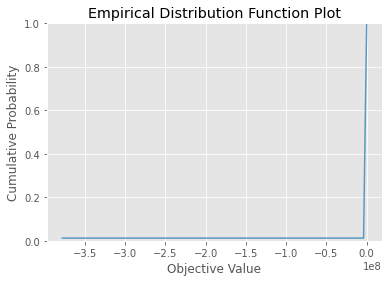

In [52]:
#Visualize empirical distribution function
optuna.visualization.matplotlib.plot_edf(study)

<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

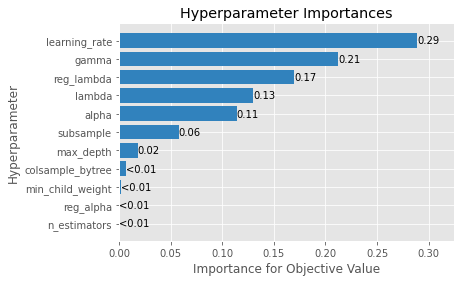

In [53]:
#Visualize parameter importances.
optuna.visualization.matplotlib.plot_param_importances(study)

In [54]:
tuned_model = xgb.XGBRegressor(**trial.params) 
tuned_model.fit(X_train, y_train)
y_preds = tuned_model.predict(X_test)
r2_train = r2_score(y_train, tuned_model.predict(X_train))
r2_test = r2_score(y_test, y_preds)
print("R2 score for XGBoost model (test):", r2_test)
print("R2 score for XGBoost model (train):", r2_train)

R2 score for XGBoost model (test): 0.7786232526434065
R2 score for XGBoost model (train): 0.9887110548607402
